In [3]:
import inferelator_ng.prior as priors
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Generate ChipSeq priors from metadata and mm10 references
This notebook loops over different references (genebody and tss), different distances to references, samples, and genes per sample, to create priors. Priors are also combined across samples. 

In [4]:
base_dir='/Users/ndeveaux/Dropbox (Simons Foundation)/atac_parameter_search/ChipSeq/chipseq_priors/chipseq_mm10_th17_prior_gen_2017_01'

In [5]:
input_base_dir = os.path.join(base_dir, 'references')
output_base_dir = os.path.join(base_dir, 'output')

In [6]:
if not os.path.exists(output_base_dir):
    os.makedirs(output_base_dir)

In [7]:
macs_folders = ['2016_11_28_MACS_out', '2016_11_15_MACS_out']
references = ['tss_mm10.bed', 'genebodies_mm10.bed']
macs_dict = {'2016_11_28_MACS_out': 'macs_pval_1e-10', '2016_11_15_MACS_out': 'macs_pval_1e-5'}

In [8]:
metadata_file = os.path.join(input_base_dir, 'metadata_ChIP.txt')
metadata = pd.read_csv(metadata_file, sep = '\t')

In [9]:
dists=[5000, 10000]

In [9]:
computed_priors = {}

In [54]:
# compute priors
for row in metadata.iterrows():
    row_content = row[1]
    sample = ('_').join([row_content['sampleName'], row_content['compare2']])
    gene = row_content['gene']
    for ref in references:
        ref_bed = os.path.join(input_base_dir, ref)
        # get human readable name
        ref_name = ref.split('.')[0]
        ref_df = pd.read_csv(ref_bed, sep = '\t', header=None)
        for mac in macs_folders:
            mac_name = macs_dict[mac]
            for dist in dists:
                motif_bed = os.path.join(os.path.join(os.path.join(input_base_dir, mac), sample), '_'.join([sample, 'peaks.bed']))
                p = priors.Prior(motif_bed, ref_bed, regulators = [gene], targets = list(ref_df[3]), max_distance=dist, single_tf=True, mode='window')
                key = '_'.join([ref_name, mac_name, str(dist), gene])
                print key + ': ' + sample
                if key not in computed_priors.keys():
                    computed_priors[key] = {}
                if sample not in computed_priors[key].keys():
                    computed_priors[key][sample] = p.make_prior()

tss_mm10_macs_pval_1e-10_5000_Batf: SL3033_SL3036
tss_mm10_macs_pval_1e-10_10000_Batf: SL3033_SL3036
tss_mm10_macs_pval_1e-5_5000_Batf: SL3033_SL3036
tss_mm10_macs_pval_1e-5_10000_Batf: SL3033_SL3036
genebodies_mm10_macs_pval_1e-10_5000_Batf: SL3033_SL3036
genebodies_mm10_macs_pval_1e-10_10000_Batf: SL3033_SL3036
genebodies_mm10_macs_pval_1e-5_5000_Batf: SL3033_SL3036
genebodies_mm10_macs_pval_1e-5_10000_Batf: SL3033_SL3036
tss_mm10_macs_pval_1e-10_5000_Batf: SL3037_SL3036
tss_mm10_macs_pval_1e-10_10000_Batf: SL3037_SL3036
tss_mm10_macs_pval_1e-5_5000_Batf: SL3037_SL3036
tss_mm10_macs_pval_1e-5_10000_Batf: SL3037_SL3036
genebodies_mm10_macs_pval_1e-10_5000_Batf: SL3037_SL3036
genebodies_mm10_macs_pval_1e-10_10000_Batf: SL3037_SL3036
genebodies_mm10_macs_pval_1e-5_5000_Batf: SL3037_SL3036
genebodies_mm10_macs_pval_1e-5_10000_Batf: SL3037_SL3036
tss_mm10_macs_pval_1e-10_5000_Batf: SL10570_SL10564
tss_mm10_macs_pval_1e-10_10000_Batf: SL10570_SL10564
tss_mm10_macs_pval_1e-5_5000_Batf: SL10

In [55]:
# combine priors into dataframe, sum and save
dataframes = {}
for k in computed_priors:
    gene = k.split('_')[-1]
    result = pd.DataFrame([computed_priors[k][sample][gene].rename(sample) for sample in computed_priors[k]]).transpose()
    result['combined_' + gene] = result.sum(axis=1)
    output_filename = '.'.join([k, 'csv'])
    result.to_csv(os.path.join(output_base_dir, output_filename))
    dataframes[k] = result

In [40]:
dataframes = {}
for f in os.listdir(output_base_dir):
    if 'Nick' not in f:
        dataframes[f.rstrip('.csv')] = pd.read_csv(os.path.join(output_base_dir, f), index_col = 0)


In [50]:
kgXref = pd.read_csv(os.path.join(base_dir, 'kgXref.txt'), sep='\t', header=None, index_col=0)

In [43]:
collapsed_on_genes_tfs = {}
for ref in references:
    ref_name = ref.split('.')[0]
    for mac in macs_folders:
        mac_name = macs_dict[mac]
        for dist in dists:
            new_key = '_'.join([ref_name, mac_name, str(dist)])
            print new_key
            columns = []
            for gene in set(metadata['gene']):
                key = '_'.join([ref_name, mac_name, str(dist), gene])
                columns.append(dataframes[key]['combined_' + gene].rename(gene))
            collapsed_on_genes_tfs[new_key] = pd.DataFrame(columns)


tss_mm10_macs_pval_1e-10_5000
tss_mm10_macs_pval_1e-10_10000
tss_mm10_macs_pval_1e-5_5000
tss_mm10_macs_pval_1e-5_10000
genebodies_mm10_macs_pval_1e-10_5000
genebodies_mm10_macs_pval_1e-10_10000
genebodies_mm10_macs_pval_1e-5_5000
genebodies_mm10_macs_pval_1e-5_10000


In [68]:
renamed_dfs['genebodies_mm10_macs_pval_1e-10_5000'].head()

,AK135172,Xkr4,AK149000,Rp1,Rp1,Sox17,Sox17,Sox17,Sox17,Sox17,...,Gm16367,Gm16513,Vmn1r62,Vmn1r187,Vmn1r63,Vamp7,Vamp7,Spry3,Tmlhe,Zf12
Batf,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Stat3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Etv6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RORg,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Irf4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
# Visualization
df = renamed_dfs['genebodies_mm10_macs_pval_1e-10_5000'].transpose()

In [70]:
def plot(df, title):
    plt.figure(figsize=(10,50))
    sns.heatmap(df.head(2000), annot=False, fmt="h", yticklabels=False)
    plt.title(title)

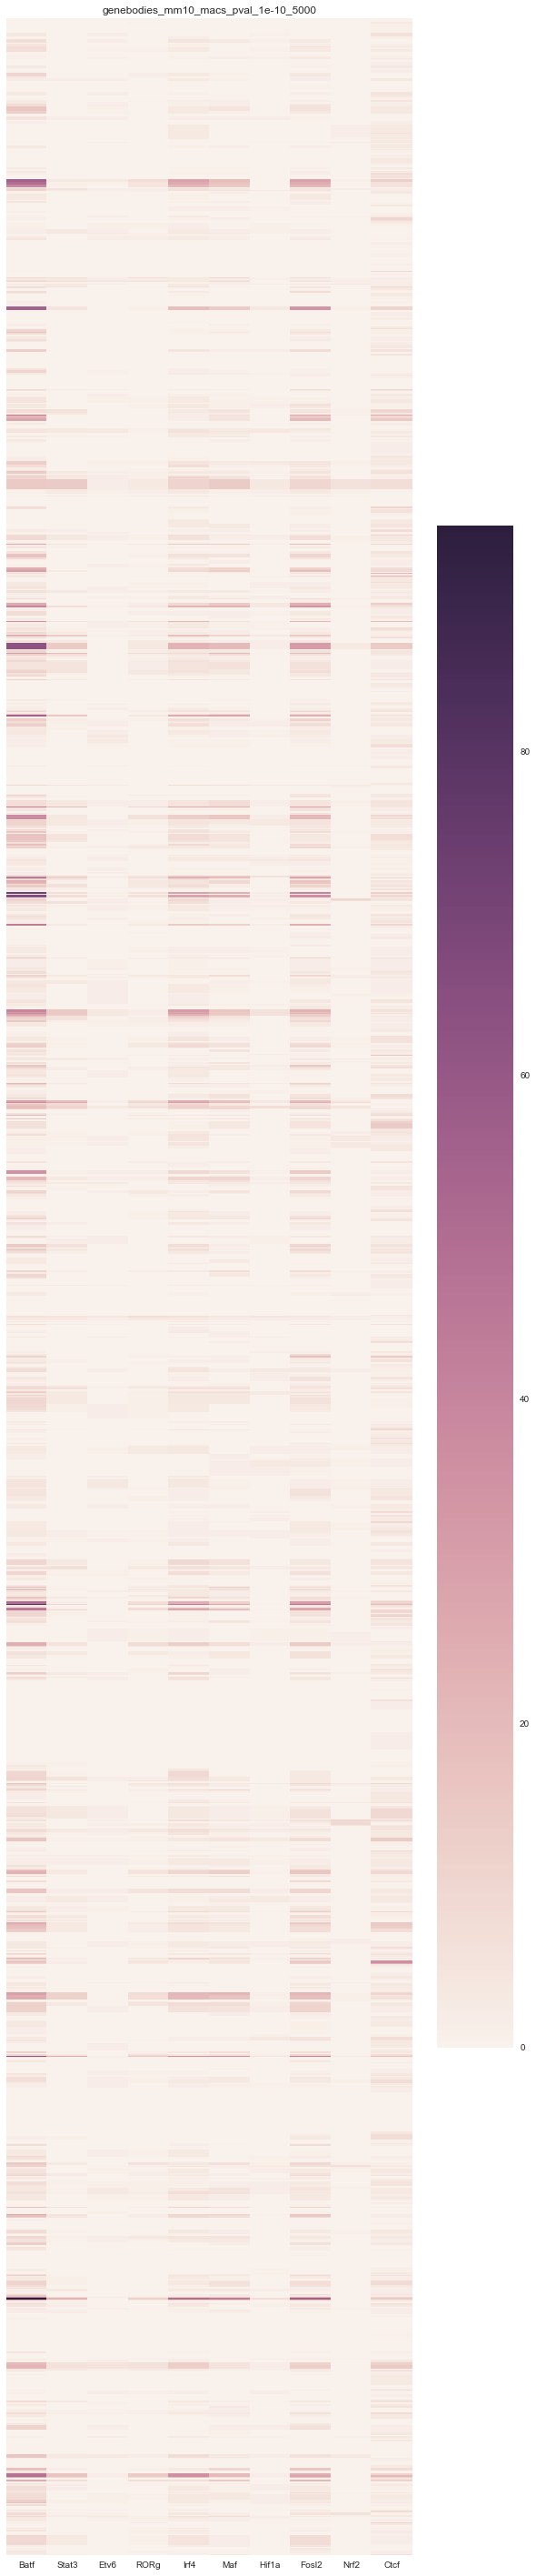

In [71]:
plot(df, 'genebodies_mm10_macs_pval_1e-10_5000')

In [67]:
# Add kgXref names
renamed_dfs = {}
for key in collapsed_on_genes_tfs:
    df = collapsed_on_genes_tfs[key]
    for column in df.columns:
        column = column.split('_')[0]
        gene_name = str(kgXref.loc[column,4])
        new_cols[column] = gene_name
    renamed_dfs[key] = df.rename(index=str, columns=new_cols)

Below is some draft space from commands I ran when working on this:

In [101]:
# Sanity check: see if prior is what's expected, 7. 
max(priors['2016_11_15_MACS_out_SL1040_SL972']['Stat3'])

7

In [72]:
# save
for k in renamed_dfs:
    result = renamed_dfs[k]
    output_filename = '.'.join([k, 'csv'])
    result.to_csv(os.path.join(output_base_dir, output_filename))

In [84]:
gene_df[gene_df[3] == 'uc011whu.1_up_1_chr1_4858327_f']

,0,1,2,3,4,5
18,chr1,4858326,4858327,uc011whu.1_up_1_chr1_4858327_f,0,+


In [110]:
new_prior = priors['2016_11_15_MACS_out_SL1040_SL972']
new_prior[new_prior['Stat3'] > 6]

,TF
uc057alc.1_up_1_chr8_35620774_f,7
uc009mmr.2_up_1_chr8_84662853_r,7
uc009nyw.2_up_1_chr8_126593437_r,7
uc011ybs.1_up_1_chr11_86584159_r,7


In [97]:
motif_bed='/Users/ndeveaux/Dropbox (Simons Foundation)/atac_parameter_search/ChipSeq/2016_11_22_performance_test_output/SL1040_SL972_peaks.bed'